In [4]:
import pickle
import argparse
import itertools
from torch_geometric.loader import DataLoader
import numpy as np
import os
import sys
from subprocess import call
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx

from tree_sitter import Parser, Node

/opt/homebrew/Caskroom/miniforge/base/envs/graph/lib/python3.11/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/graph/lib/python3.11/site-packages/libpyg.so, 0x0006): tried: '/opt/homebrew/Caskroom/miniforge/base/envs/graph/lib/python3.11/site-packages/libpyg.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/Caskroom/miniforge/base/envs/graph/lib/python3.11/site-packages/libpyg.so' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/graph/lib/python3.11/site-packages/libpyg.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/homebrew/Caskroom/miniforge/base/envs/graph/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please upd

In [5]:
def run_system_command(cmd: str,
                       shell: bool = False,
                       err_msg: str = None,
                       verbose: bool = True,
                       split: bool = True,
                       stdout=None,
                       stderr=None) -> int:
    """
    :param cmd: A string with the terminal command invoking an external program
    :param shell: Whether the command should be executed through the shell
    :param err_msg: Error message to print if execution fails
    :param verbose: Whether to print the command to the standard output stream
    :param split: Whether to split the tokens in the command string
    :param stdout: file pointer to redirect stdout to
    :param stderr: file pointer to redirect stderr to
    :return: Return code
    """
    if verbose:
        sys.stdout.write("System cmd: {}\n".format(cmd))
    if split:
        cmd = cmd.split()
    rc = call(cmd, shell=shell, stdout=stdout, stderr=stderr)
    if err_msg and rc:
        sys.stderr.write(err_msg)
        exit(rc)
    return rc

In [46]:
def draw_graph(G, label=None):
    fig, ax = plt.subplots(figsize=(40, 20))
    ax.axis(False)
    pos = nx.nx_agraph.graphviz_layout(G, 'dot')
    if label:
        labels = nx.get_node_attributes(G, label)
    else:
        labels = None

def add_string_literal(s : str):
    return '"' + s + '"'

def remove_string_literal(s: str):
    return s[1:-1]

In [47]:
def initialize_cpp_tree_sitter():
    TREE_SITTER_PATH = "./tree-sitter-cpp"
    Path(TREE_SITTER_PATH).mkdir(exist_ok= True)
    TREE_SITTER_CPP_URL = "https://github.com/tree-sitter/tree-sitter-cpp.git"


    # Intial tree sitter
    from tree_sitter import Language

    if os.path.exists(TREE_SITTER_PATH) == False:
        run_system_command("git clone {}".format(TREE_SITTER_CPP_URL), verbose = False)

    Language.build_library(
    # Store the library in the `build` directory
    'build/my-languages.so',

    # Include one or more languages
    [
        TREE_SITTER_PATH
    ]
    )

    CPP_LANGUAGE = Language('build/my-languages.so', "cpp")

    return CPP_LANGUAGE

In [48]:
def transform_graph(root):
    G = nx.DiGraph()
    
    todo = [root]
    paths = []

    while todo:
        node = todo.pop()
        node_text = node.text.decode("utf-8")
        
        G.add_node(node.id, label = add_string_literal(node.type))
        if node.children == []:
            G.nodes[node.id]["label"] = add_string_literal(node.type + "_" + node_text)
        else:
            for child in node.children:
                todo.append(child)
                G.add_edge(node.id, child.id)                
                
    return G

In [49]:
def extract_ast_path(root, max_length = 10):
    G = transform_graph(root)

    paths = []
    root_id = root.id
    
    for node_id in G:
        if G.out_degree(node_id) == 0:
            path = nx.shortest_path(G, root_id, node_id)
            
            if len(path) > max_length: path = path[-1 - (max_length + 1) : -1]
            
            for idx, node in enumerate(path):
                path[idx] = remove_string_literal(G.nodes[node]["label"])
                
            paths.append(path)

    return G, paths

In [52]:
def extract_code2vec_ast_path(root, max_length = 9, max_width  = 2):
    G = transform_graph(root)
    
    paths = []
    root_id = root.id

    child_node_list = []
    for node_id in G:
        if G.out_degree(node_id) == 0: child_node_list.append(node_id)

    G = G.to_undirected()

    for left_node_idx, left_node in enumerate(child_node_list):
        if max_width == None:
            max_idx = len(child_node_list)
        else:
            max_idx = min(left_node_idx + 1 + max_width, len(child_node_list))

        for right_node_idx, right_node in enumerate(child_node_list[left_node_idx + 1 :max_idx]):
            path = nx.shortest_path(G, left_node, right_node)

            if max_length == None or len(path) <= max_length:
                for idx, node in enumerate(path):
                    path[idx] = remove_string_literal(G.nodes[node]["label"])
                paths.append(path)
        
    return G, paths

int main() {
	int a[N];
}

['primitive_type_int', 'function_definition', 'compound_statement', '{_{']
['primitive_type_int', 'function_definition', 'compound_statement', '}_}']
['{_{', 'compound_statement', '}_}']
['{_{', 'compound_statement', 'declaration', 'primitive_type_int']
['}_}', 'compound_statement', 'declaration', 'primitive_type_int']
['}_}', 'compound_statement', 'declaration', ';_;']
['primitive_type_int', 'declaration', ';_;']
['primitive_type_int', 'declaration', 'array_declarator', 'identifier_a']
[';_;', 'declaration', 'array_declarator', 'identifier_a']
[';_;', 'declaration', 'array_declarator', '[_[']
['identifier_a', 'array_declarator', '[_[']
['identifier_a', 'array_declarator', 'identifier_N']
['[_[', 'array_declarator', 'identifier_N']
['[_[', 'array_declarator', ']_]']
['identifier_N', 'array_declarator', ']_]']
['identifier_N', 'array_declarator', 'declaration', 'compound_statement', 'function_definition', 'function_declarator', 'identifier_main']
[']_]', 'arra

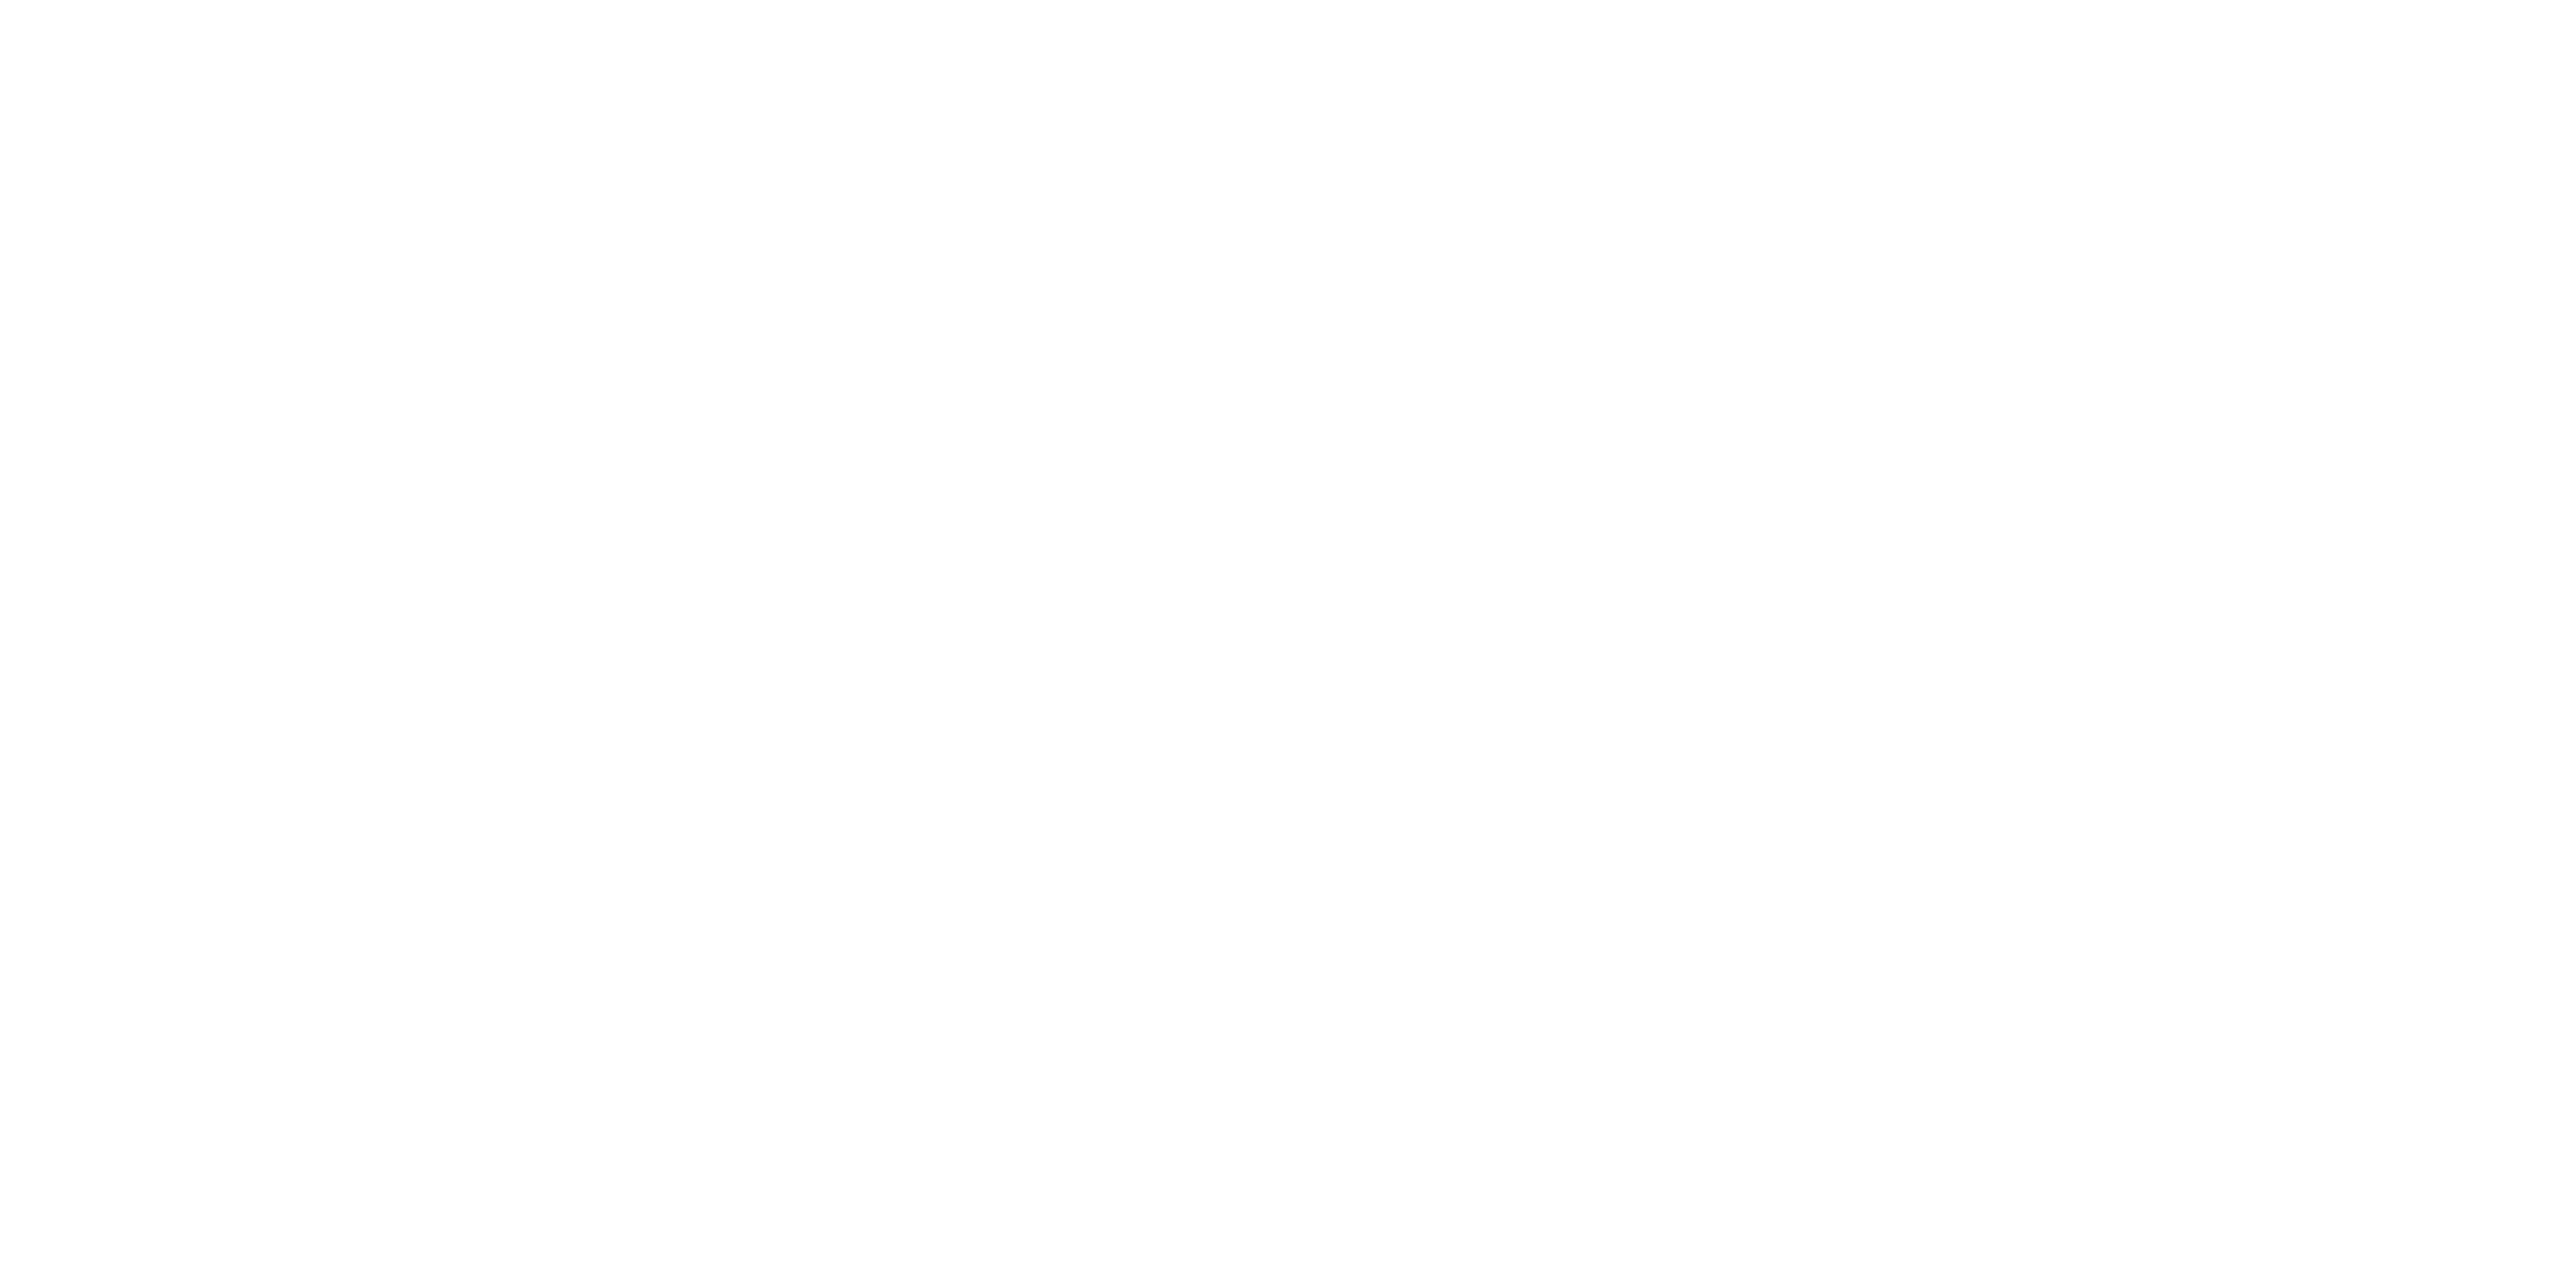

In [53]:
infile = open("./sample.cpp")
sample = infile.read()

print(sample)

CPP_LANGUAGE = initialize_cpp_tree_sitter()

# CPP Parser
parser = Parser()
parser.set_language(CPP_LANGUAGE)

tree = parser.parse(bytes(sample, "utf-8"))
root = tree.root_node

graph, paths = extract_code2vec_ast_path(root)

[print(path) for path in paths]
print(len(paths))

draw_graph(graph, "type")
nx.drawing.nx_pydot.write_dot(graph, "sample.dot")